In [1]:
# Imports e configurações
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from glob import glob
from sklearn.model_selection import train_test_split
import zipfile
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2

# --- Variáveis Globais Corrigidas e Adicionais ---
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 32
VAL_SPLIT = 0.2
EPOCHS = 30 # Aumentado para Fine-Tuning
DATA_DIR = 'dataset' # Diretório para extrair os dados

# Configurações para reprodutibilidade
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Instalar kaggle (execute apenas se precisar baixar do Kaggle via API)
# No Colab, rode esta célula e em seguida faça upload do kaggle.json quando solicitado.
!pip install kaggle --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 141.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


In [3]:
# Cria o diretório .kaggle se não existir
!mkdir -p ~/.kaggle

# Move o kaggle.json enviado para o diretório
!cp kaggle.json ~/.kaggle/

# Garante permissões de leitura/escrita
!chmod 600 ~/.kaggle/kaggle.json

# Baixa o dataset do Kaggle
# Dataset: plameneduardo/sarscov2-ctscan-dataset
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset -p .

# Renomeia o arquivo baixado para um nome fixo
zip_file_name = 'sarscov2-ctscan-dataset.zip'
if os.path.exists('sarscov2-ctscan-dataset.zip'):
    print("Arquivo zip já baixado.")
else:
    # Tenta encontrar o arquivo zip
    downloaded_files = glob('*.zip')
    if downloaded_files:
        os.rename(downloaded_files[0], zip_file_name)
    else:
        print("Erro: Arquivo ZIP não encontrado após o download.")

# Cria o diretório de dados e extrai
os.makedirs(DATA_DIR, exist_ok=True)
if os.path.exists(zip_file_name):
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print(f"Conteúdo de {zip_file_name} extraído para {DATA_DIR}/")
else:
    print(f"Erro: Arquivo {zip_file_name} não existe para extração.")

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset
License(s): CC-BY-NC-SA-4.0
 97% 223M/230M [00:02<00:00, 142MB/s]
100% 230M/230M [00:02<00:00, 113MB/s]
Arquivo zip já baixado.
Conteúdo de sarscov2-ctscan-dataset.zip extraído para dataset/


In [4]:
def list_images(data_dir):
    # Procura imagens diretamente em subdiretórios dentro de data_dir
    files = []
    for root, dirs, fnames in os.walk(data_dir):
        for fname in fnames:
            if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                files.append(os.path.join(root, fname))
    return sorted(files)

all_images = list_images(DATA_DIR)
print("Total imagens encontradas:", len(all_images))

if not all_images:
    print("ERRO: Nenhuma imagem encontrada. Verifique o caminho DATA_DIR e a extração.")
    # Adicionando um exit se não houver dados
    # raise FileNotFoundError("Não há imagens para processar.")

train_files, val_files = train_test_split(
    all_images,
    test_size=VAL_SPLIT,
    random_state=SEED,
    shuffle=True
)

print("Train files:", len(train_files), "Val files:", len(val_files))

Total imagens encontradas: 2481
Train files: 1984 Val files: 497


In [6]:
# Augmentations (aplicadas apenas no treino)
train_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=SEED),
    tf.keras.layers.RandomRotation(0.05, seed=SEED),
    tf.keras.layers.RandomContrast(0.1, seed=SEED),
])

def decode_image(path):
    img_bytes = tf.io.read_file(path)
    # Tenta decodificar a imagem de forma genérica
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)

    # Garante o shape e o redimensionamento
    img = tf.ensure_shape(img, [None, None, 3])
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    # Normalização
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Obtém a lista de classes do diretório
# A lista deve ser ['CT_NonCOVID', 'CT_COVID']
classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print("Classes encontradas:", classes)

def get_label(file_path):
    # Convert os.path.sep to a tf.constant string for graph compatibility
    parts = tf.strings.split(file_path, tf.constant(os.path.sep))
    class_name = parts[-2]
    class_names_tensor = tf.constant(classes)
    eq = tf.equal(class_names_tensor, class_name)

    # CORREÇÃO: Cast para INT32 para rótulos de classificação
    idx = tf.cast(tf.argmax(tf.cast(eq, tf.int32)), tf.int32)
    return idx

def load_train(path):
    img = decode_image(path)
    # REATIVADO: Aplica data augmentation
    img = train_augmentation(img)
    label = get_label(path)
    # CORREÇÃO: Garante que o rótulo tenha a dimensão (1,) para corresponder ao modelo
    label = tf.expand_dims(label, axis=-1)
    return img, label

def load_val(path):
    img = decode_image(path)
    label = get_label(path)
    # CORREÇÃO: Garante que o rótulo tenha a dimensão (1,)
    label = tf.expand_dims(label, axis=-1)
    return img, label

Classes encontradas: ['COVID', 'non-COVID']


In [7]:
train_ds = tf.data.Dataset.from_tensor_slices(train_files)
train_ds = train_ds.shuffle(len(train_files), seed=SEED)
train_ds = train_ds.map(load_train, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(val_files)
val_ds = val_ds.map(load_val, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(train_ds.element_spec)
print(val_ds.element_spec)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))


In [8]:
# Cria o modelo base EfficientNetB0
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# --- Configuração de Fine-Tuning ---
base_model.trainable = True # DESCONGELA o modelo base inteiro

# Congela as primeiras camadas, liberando as últimas 20 para treinamento
fine_tune_at = len(base_model.layers) - 20
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Cria o modelo sequencial
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=True) # training=True é importante para BatchNorm no Fine-Tuning
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3, seed=SEED)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

# Recompilação com uma taxa de aprendizado MUITO BAIXA (1e-5)
# Isso evita a destruição dos pesos pré-treinados
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
print(f"Total de camadas descongeladas (trainable): {len([layer for layer in model.trainable_weights if layer.trainable])}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,352,241 (5.16 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

Total de camadas descongeladas (trainable): 21


In [9]:
checkpoint_path = "best_model_finetuned.h5" # Novo nome para o checkpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1), # Aumenta a paciência
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

print(f"Iniciando treinamento com Fine-Tuning por até {EPOCHS} épocas...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Iniciando treinamento com Fine-Tuning por até 30 épocas...
Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.5028 - loss: 0.7005
Epoch 1: val_loss improved from inf to 0.70187, saving model to best_model_finetuned.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 71s 605ms/step - accuracy: 0.5028 - loss: 0.7004 - val_accuracy: 0.4809 - val_loss: 0.7019 - learning_rate: 1.0000e-05
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4896 - loss: 0.7007
Epoch 2: val_loss did not improve from 0.70187
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.4897 - loss: 0.7007 - val_accuracy: 0.4809 - val_loss: 0.7065 - learning_rate: 1.0000e-05
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.4951 - loss: 0.6950
Epoch 3: val_loss did not improve from 0.70187
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - accuracy: 0.4951 - loss: 0.6950 - val_accuracy: 0.4809 - val_loss: 0.7076 - learning_rate: 1.0000e-05
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5222 - loss: 0.6912
Epoch 4: val_loss did not improve from 0.70187

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 347ms/step - accuracy: 0.5222 - loss: 0.6913 - val_accu

62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.5444 - loss: 0.6938 - val_accuracy: 0.4809 - val_loss: 0.6990 - learning_rate: 5.0000e-06
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.5025 - loss: 0.6951
Epoch 7: val_loss improved from 0.69897 to 0.69830, saving model to best_model_finetuned.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.5025 - loss: 0.6951 - val_accuracy: 0.4809 - val_loss: 0.6983 - learning_rate: 5.0000e-06
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.5175 - loss: 0.6963
Epoch 8: val_loss improved from 0.69830 to 0.69563, saving model to best_model_finetuned.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 360ms/step - accuracy: 0.5173 - loss: 0.6963 - val_accuracy: 0.4809 - val_loss: 0.6956 - learning_rate: 5.0000e-06
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4889 - loss: 0.7029
Epoch 9: val_loss did not improve from 0.69563
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 346ms/step - accuracy: 0.4890 - loss: 0.7029 - val_accuracy: 0.4809 - val_loss: 0.6959 - learning_rate: 5.0000e-06
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5175 - loss: 0.6933
Epoch 10: val_loss improved from 0.69563 to 0.69520, saving model to best_model_finetuned.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step - accuracy: 0.5173 - loss: 0.6933 - val_accuracy: 0.4809 - val_loss: 0.6952 - learning_rate: 5.0000e-06
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5346 - loss: 0.6928
Epoch 11: val_loss improved from 0.69520 to 0.69500, saving model to best_model_finetuned.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - accuracy: 0.5343 - loss: 0.6928 - val_accuracy: 0.4809 - val_loss: 0.6950 - learning_rate: 5.0000e-06
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5309 - loss: 0.6903
Epoch 12: val_loss improved from 0.69500 to 0.69485, saving model to best_model_finetuned.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 370ms/step - accuracy: 0.5306 - loss: 0.6903 - val_accuracy: 0.4809 - val_loss: 0.6948 - learning_rate: 5.0000e-06
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.5232 - loss: 0.6919
Epoch 13: val_loss improved from 0.69485 to 0.69454, saving model to best_model_finetuned.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 353ms/step - accuracy: 0.5231 - loss: 0.6919 - val_accuracy: 0.4809 - val_loss: 0.6945 - learning_rate: 5.0000e-06
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5123 - loss: 0.6932
Epoch 14: val_loss improved from 0.69454 to 0.69417, saving model to best_model_finetuned.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 355ms/step - accuracy: 0.5124 - loss: 0.6932 - val_accuracy: 0.4809 - val_loss: 0.6942 - learning_rate: 5.0000e-06
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4839 - loss: 0.7004
Epoch 15: val_loss did not improve from 0.69417
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 328ms/step - accuracy: 0.4842 - loss: 0.7003 - val_accuracy: 0.4809 - val_loss: 0.6942 - learning_rate: 5.0000e-06
Epoch 16/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.4919 - loss: 0.6998
Epoch 16: val_loss improved from 0.69417 to 0.69400, saving model to best_model_finetuned.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4920 - loss: 0.6998 - val_accuracy: 0.4809 - val_loss: 0.6940 - learning_rate: 5.0000e-06
Epoch 17/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5078 - loss: 0.6928
Epoch 17: val_loss did not improve from 0.69400
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - accuracy: 0.5081 - loss: 0.6928 - val_accuracy: 0.4809 - val_loss: 0.6943 - learning_rate: 5.0000e-06
Epoch 18/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4871 - loss: 0.6992
Epoch 18: val_loss did not improve from 0.69400
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 342ms/step - accuracy: 0.4871 - loss: 0.6991 - val_accuracy: 0.4809 - val_loss: 0.6964 - learning_rate: 5.0000e-06
Epoch 19/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4844 - loss: 0.6990
Epoch 19: val_loss did not improve from 0.69400

Epoch 19: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 328ms/step - accuracy: 0.4846 - loss: 0.6989 - v


             RELATÓRIO DE CLASSIFICAÇÃO
              precision    recall  f1-score   support

       COVID       0.48      1.00      0.65       239
   non-COVID       0.00      0.00      0.00       258

    accuracy                           0.48       497
   macro avg       0.24      0.50      0.32       497
weighted avg       0.23      0.48      0.31       497



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


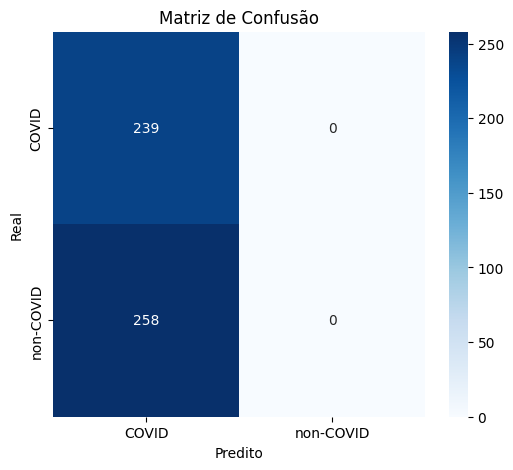

In [10]:
# Carrega o melhor modelo salvo pelo callback
model.load_weights(checkpoint_path)

y_true = []
y_pred = []

# Coleta predições e rótulos reais
for batch_images, batch_labels in val_ds:
    # O modelo retorna logits (saída da sigmoid)
    preds_logits = model.predict(batch_images, verbose=0)

    # Converte logits para predições binárias (0 ou 1)
    preds = (preds_logits.flatten() > 0.5).astype(int)

    # Achata os rótulos reais que têm shape (BATCH_SIZE, 1)
    real_labels = batch_labels.numpy().flatten().tolist()

    y_pred.extend(preds.tolist())
    y_true.extend(real_labels)

# Garante que o número de classes no classification_report corresponda ao número de classes
target_names = classes[:len(classes)] if len(classes) > 1 else ['0', '1']

print("\n" + "="*50)
print("             RELATÓRIO DE CLASSIFICAÇÃO")
print("="*50)
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()